In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scanpy.external as sce
import numpy as np
import gseapy as gp
import liana as li
import anndata as ad
from scipy import stats
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
from sklearn.decomposition import PCA
import glob as glob
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
#files=glob.glob('../Data/snRNAseq/**.h5ad')
files=glob.glob('/Volumes/Extreme SSD/FLC_CXCL12_Code/Data/**.h5ad')
for i,file in enumerate(files):
    if i==0:
        adata=ad.read_h5ad(file)
    else:
        adata=ad.concat((adata,ad.read_h5ad(file)),join='outer')
adata

AnnData object with n_obs × n_vars = 255639 × 4132
    obs: 'Sample', 'Condition', 'total_counts', 'gene_count', 'Celltype_Broad', 'Celltype', 'Celltype_forCellchat'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [3]:
adata

AnnData object with n_obs × n_vars = 255639 × 4132
    obs: 'Sample', 'Condition', 'total_counts', 'gene_count', 'Celltype_Broad', 'Celltype', 'Celltype_forCellchat'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [4]:
cell_type_colors = {
    'Macrophage': '#DAA520',
    'T cell': '#1E90FF',
    'Pericyte': '#fccde5',
    'Vascular mural': '#fccde5',
    'B cell': '#FF0000',
    'Venous': '#bc80bd',
    'Endothelial':'#bc80bd',
    'Kupffer cell': 'orange',
    'cDC': 'forestgreen',
    'mregDC': 'limegreen',
    'myCAF': '#d6616b',
    'pDC': 'purple',
    'LSEC': '#fdb462',
    'Arterial': '#bc5a45',
    'vSMC': '#66c2a5',
    'LEC': '#8c6d31',
    'HSC':'#cedb9c',
    'Treg': '#b5cf6b',
    'Mast cell': '#e7969c',
    'pDC':'purple',
    'Treg':'#FF7F50',
    'NK cell':'#FFC0CB',
    'B cell':'#FF0000',
    'Tumor':'#80b1d3',
    'Hepatocyte':'#fb8072',
    'Mixed':'#ae017e',
    'Cholangiocyte':'#fdb462',
    "Endothelial":"#fccde5",
    "Epithelial":"#8dd3c7",
    "Immune":"#74c476",
    "Mesenchymal":"#bebada",
    'ANTL':'Grey',
    'Primary':'Blue',
    'Metastatic':'Red'
}

### Figure 1B

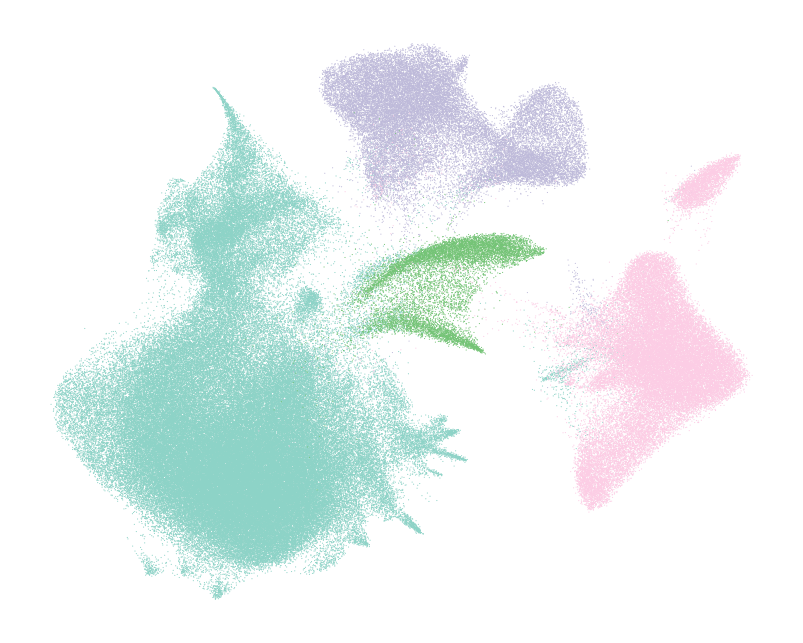

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
sc.set_figure_params(fontsize=6)

sc.pl.umap(
    adata,
    color=['Celltype_Broad'],
    ncols=1,
    title='',palette=cell_type_colors,
    ax=ax, 
    show=False,size=1,frameon=False
)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show(fig) 

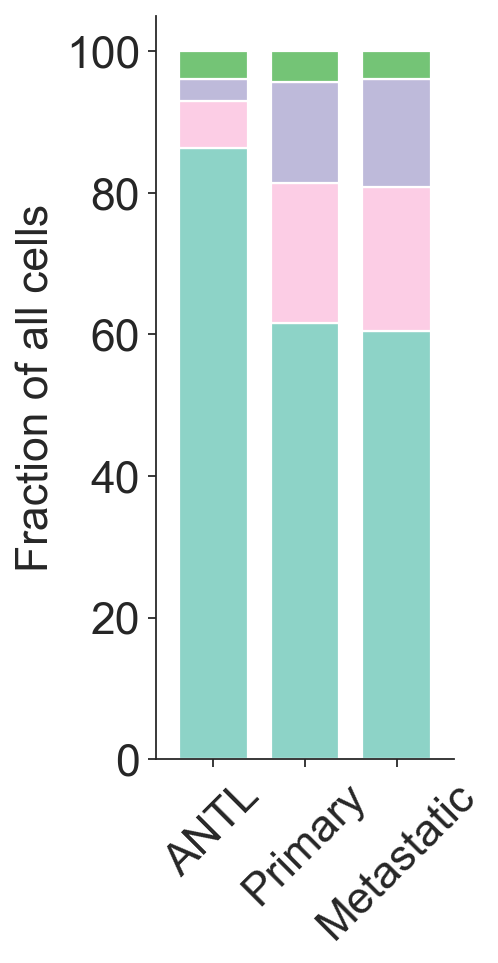

In [6]:
sns.set_style('ticks')
df=adata.obs
df_pivot = pd.crosstab(df['Condition'], df['Celltype_Broad'])
df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100
df_pivot_percentage=df_pivot_percentage[df_pivot_percentage.mean().sort_values().index[::-1]].loc[['ANTL','Primary','Metastatic']]
df_pivot_percentage.plot(kind='bar', stacked=True, figsize=(3,6),color=cell_type_colors,width=0.75)
plt.title('')
plt.xlabel('')
plt.ylabel('Fraction of all cells',fontsize=20)
sns.despine()
plt.yticks(fontsize=20)
plt.xticks(np.arange(3),['ANTL','Primary','Metastatic'],fontsize=20,rotation=45)
plt.gca().set_axisbelow(True)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show()

### Supplemental Figure 1

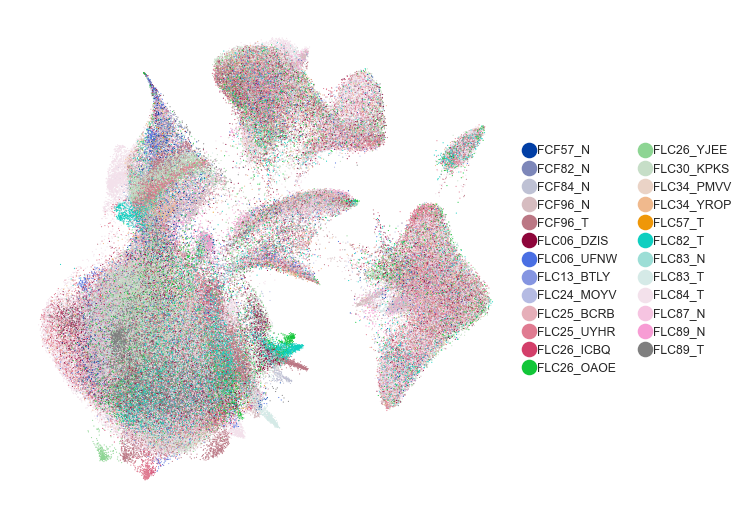

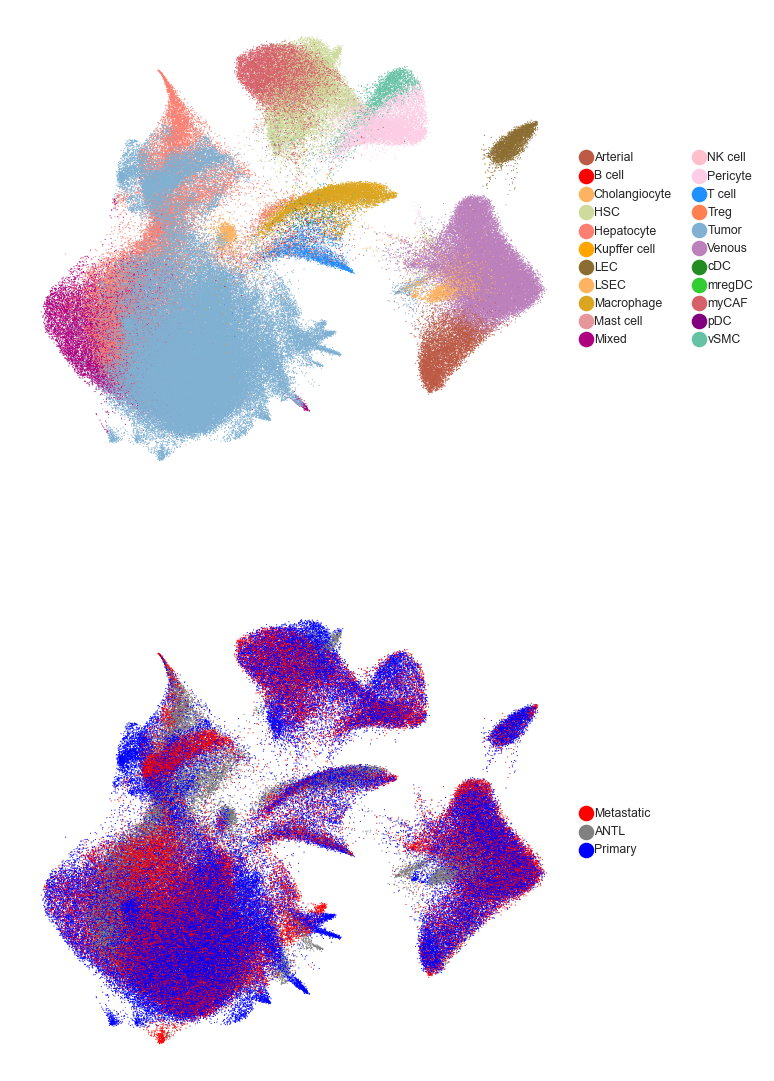

In [7]:
sc.pl.umap(
    adata,
    color=['Sample'],
    ncols=1,
    title='',
    show=False,size=1,frameon=False
)
plt.show()
plt.close()

sc.pl.umap(
    adata,
    color=['Celltype','Condition'],
    ncols=1,
    title=['',''],palette=cell_type_colors,
    show=False,size=1,frameon=False
)

plt.show()
plt.close()

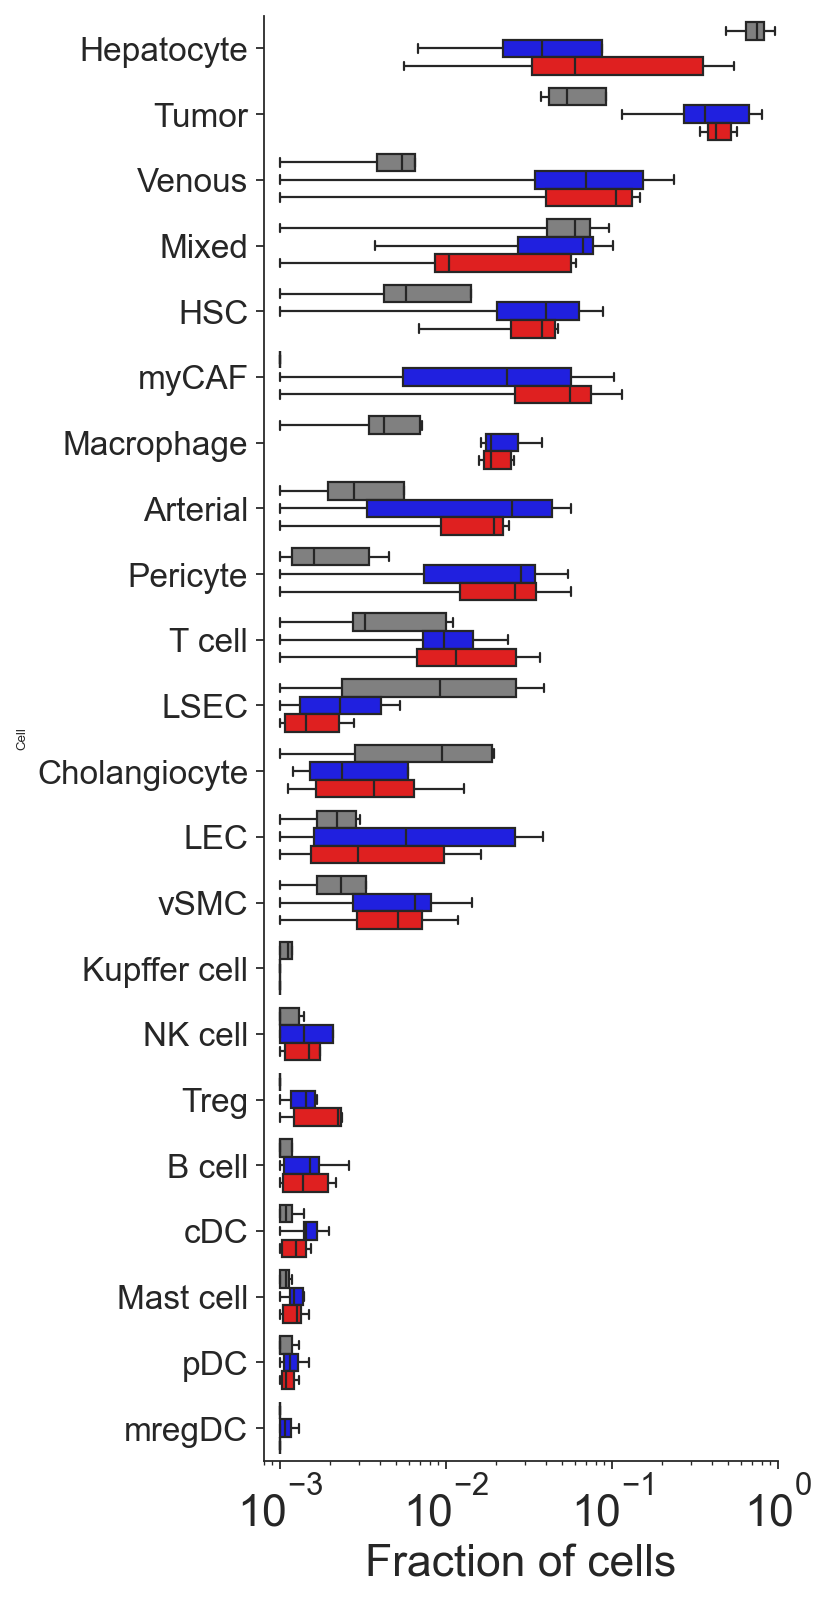

In [8]:
def plot_freq(adata):
    df=pd.DataFrame(np.zeros((adata.obs.Celltype.unique().shape[0],adata.obs.Sample.unique().shape[0])),
                index=adata.obs.Celltype.unique(),
                columns=adata.obs.Sample.unique())
    status=[]
    for i,x in enumerate(adata.obs.Sample.unique()):
        a,b=np.unique(adata[adata.obs.Sample==x].obs.Celltype,return_counts=1)
        df.loc[a,x]=b/sum(b)
        status.append(adata[adata.obs.Sample==x].obs.Condition.iloc[0])
    order=df.mean(axis=1).sort_values()[::-1].index
    df['Cell']=df.index
    df=df.melt(id_vars='Cell')
    df['Hue']=[adata[adata.obs.Sample==x].obs.Condition.iloc[0] for x in df.variable]
    df.value=df.value+10e-4

    plt.figure(figsize=(5,10))
    sns.set_style('white')
    sns.set_style('ticks')
    sns.boxplot(y='Cell',x='value',hue='Hue',data=df,order=order,hue_order=['ANTL','Primary','Metastatic'],fliersize=0,
               palette=cell_type_colors)
    plt.yticks(rotation=0,fontsize=15)
    plt.xscale('log')
    sns.despine()
    plt.legend(frameon=False)
    plt.xlabel('Fraction of cells',fontsize=20)
    plt.xticks(fontsize=20)
    plt.tight_layout()
    sns.despine()
    plt.legend('',frameon=False)
    plt.xlim([8e-4,1])
    plt.show()
    plt.close()

plot_freq(adata)

### Figure 1C

In [9]:
Pseudo_df_all = pd.read_csv("../Data/snRNAseq/Pseudobulk/pseudobulk_Dseq2.csv",index_col='Unnamed: 0')
Bulk_df_all = pd.read_csv("../Data/snRNAseq/Pseudobulk/BulkRNAseq_SethupathyLab_Dseq2.csv",index_col='GeneName')
common_genes = Bulk_df_all.index.intersection(Pseudo_df_all.index)
bulk_all = Bulk_df_all.loc[common_genes]
pseudo_all = Pseudo_df_all.loc[common_genes]

In [10]:
Pseudo_df = Pseudo_df_all[Pseudo_df_all['padj']<0.01].sort_values(['log2FoldChange'], ascending=[False])
Bulk_df = Bulk_df_all[Bulk_df_all['padj']<0.01].sort_values(['log2FoldChange'], ascending=[False])

common_genes = Bulk_df.index.intersection(Pseudo_df.index)
bulk_data = Bulk_df.loc[common_genes]
pseudo_data = Pseudo_df.loc[common_genes]

bulk_data_cleaned = bulk_data[~(bulk_data['log2FoldChange'].isna() | bulk_data['log2FoldChange'].isin([np.inf, -np.inf]))]
pseudo_data_cleaned = pseudo_data[~(pseudo_data['log2FoldChange'].isna() | pseudo_data['log2FoldChange'].isin([np.inf, -np.inf]))]

common_genes_cleaned = bulk_data_cleaned.index.intersection(pseudo_data_cleaned.index)
bulk_data_cleaned = bulk_data_cleaned.loc[common_genes_cleaned]
pseudo_data_cleaned = pseudo_data_cleaned.loc[common_genes_cleaned]

# Filter upregulated and downregulated genes
upregulated_genes = common_genes_cleaned[
    (bulk_data_cleaned['log2FoldChange'] > 1) & (pseudo_data_cleaned['log2FoldChange'] > 1) & (bulk_data_cleaned['padj'] < 0.01) & (pseudo_data_cleaned['padj'] < 0.01)
]
downregulated_genes = common_genes_cleaned[
    (bulk_data_cleaned['log2FoldChange'] < -1) & (pseudo_data_cleaned['log2FoldChange'] < -1) & (bulk_data_cleaned['padj'] < 0.01) & (pseudo_data_cleaned['padj'] < 0.01)
]

# Data for upregulated genes
bulk_up = bulk_data_cleaned.loc[upregulated_genes]
pseudo_up = pseudo_data_cleaned.loc[upregulated_genes]
correlation_up, p_value_up = pearsonr(bulk_up['log2FoldChange'], pseudo_up['log2FoldChange'])

# Data for downregulated genes
bulk_down = bulk_data_cleaned.loc[downregulated_genes]
pseudo_down = pseudo_data_cleaned.loc[downregulated_genes]
correlation_down, p_value_down = pearsonr(bulk_down['log2FoldChange'], pseudo_down['log2FoldChange'])

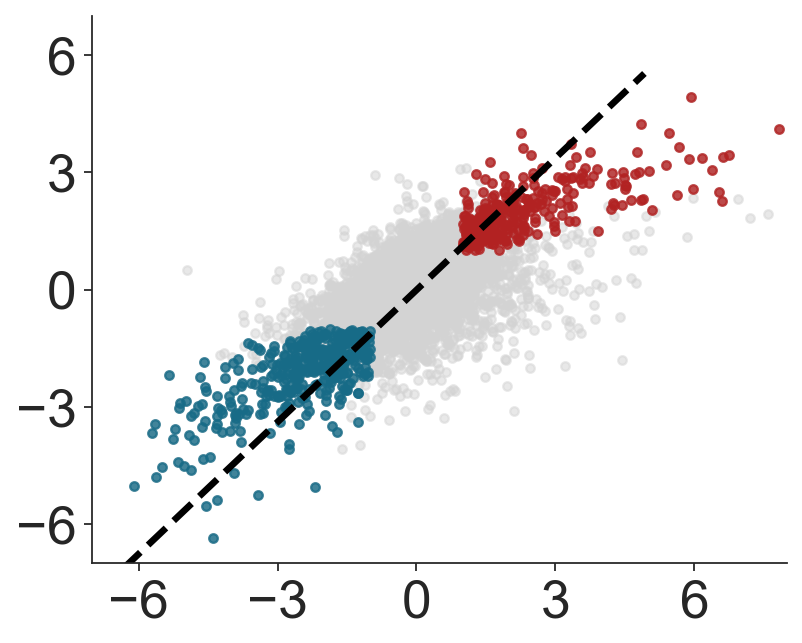

In [11]:
sc.set_figure_params(fontsize=6)
plt.figure(figsize=(5,4))

sns.set_style('white')
sns.set_style('ticks')

assert np.all(bulk_all.index==pseudo_all.index)
assert np.all(pseudo_up.index==bulk_up.index)
assert np.all(pseudo_down.index==bulk_down.index)

sns.regplot(x=np.hstack((pseudo_up['log2FoldChange'],pseudo_down['log2FoldChange'])),
    y=np.hstack((bulk_up['log2FoldChange'],bulk_down['log2FoldChange'])), ci=None,scatter=False,line_kws={'linestyle': '--', 'color': 'k','lw':'3'})

# Plot all genes
plt.scatter(
    bulk_all['log2FoldChange'], 
    pseudo_all['log2FoldChange'], 
    color='lightgray', alpha=0.5, s=15, label='All Genes'
)

# Highlight upregulated genes
plt.scatter(
    bulk_up['log2FoldChange'], 
    pseudo_up['log2FoldChange'], 
    color='firebrick', alpha=0.8, s=15, label='Upregulated in Both'
)

# Highlight downregulated genes
plt.scatter(
    bulk_down['log2FoldChange'], 
    pseudo_down['log2FoldChange'], 
    color='#176B87', alpha=0.8, s=15, label='Downregulated in Both'
)
sns.despine()
plt.xticks(np.arange(-6,12,3),fontsize=24)
plt.xlim([-7,8])

plt.yticks(np.arange(-6,9,3),fontsize=24)
plt.ylim([-7,7])
plt.tight_layout()

In [12]:
print('Differentially expressed genes R:',stats.linregress(x=np.hstack((pseudo_up['log2FoldChange'],pseudo_down['log2FoldChange'])),
    y=np.hstack((bulk_up['log2FoldChange'],bulk_down['log2FoldChange']))).rvalue.round(2))
print('All genes R:', stats.linregress(x=pseudo_all['log2FoldChange'],y=bulk_all['log2FoldChange']).rvalue.round(2))

Differentially expressed genes R: 0.94
All genes R: 0.63


### Figure 1D

In [13]:
pseudobulk_matrix=pd.read_pickle('../Data/snRNAseq/Pseudobulk/pseudobulk.pkl')
pseudo_metadata=pd.DataFrame([x.split('_') for x in pseudobulk_matrix.index],columns=['sample','condition'],index=pseudobulk_matrix.index).drop_duplicates()

In [14]:
matrix=pseudobulk_matrix.T
print(f"Original number of genes: {matrix.shape[0]}")
filtered_matrix = matrix[matrix.apply(lambda row: np.sum(row >= 100), axis=1) >= 10]
cpm_matrix = filtered_matrix.div(filtered_matrix.sum(axis=0), axis=1) * 1e7
log_matrix = cpm_matrix.map(lambda x: np.log2(x + 1))
log_matrix_filtered = log_matrix[(log_matrix > 0).any(axis=1)]
print(f"Filtered number of genes: {log_matrix_filtered.shape[0]}")
bulk_scaled = log_matrix.sub(log_matrix.mean(axis=1), axis=0).div(log_matrix.std(axis=1), axis=0)

Original number of genes: 41352
Filtered number of genes: 17311


In [15]:
FLC_sig = pd.read_excel('../Data/snRNAseq/Pseudobulk/FLC_Signature.xlsx')
gene_list = np.array(FLC_sig['Unnamed: 1'][2:]).tolist()
print('FLC signature genes:',len(gene_list))
gene_list_mtx = bulk_scaled[bulk_scaled.index.isin(gene_list)]
print('FLC signature genes meeting QC:', len(gene_list_mtx))

FLC signature genes: 693
FLC signature genes meeting QC: 543


In [16]:
cat_order = ['ANTL', 'Primary', 'Metastatic']
cat_dtype = CategoricalDtype(categories=cat_order, ordered=True)
pseudo_metadata['condition'] = pseudo_metadata['condition'].astype(cat_dtype)

<Figure size 600x450 with 0 Axes>

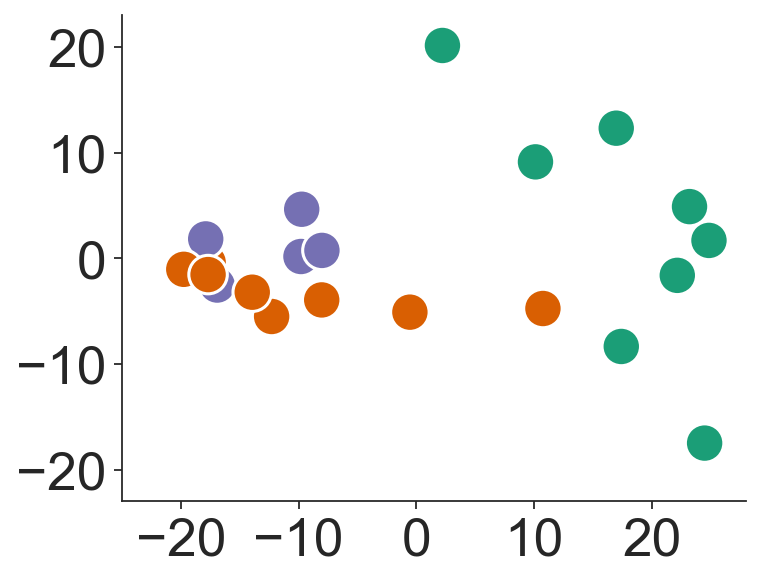

In [17]:
sc.set_figure_params(fontsize=6)
plt.figure(figsize=(2, 1.5),dpi=300) 

pca = PCA(n_components=2)
pca_results = pca.fit_transform(gene_list_mtx.T)

# Create a PCA DataFrame
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"], index=gene_list_mtx.T.index)
pca_df["condition"] = pseudo_metadata.loc[pca_df.index]['condition'].tolist()

# Plot PCA
plt.figure(figsize=(5,4))

sns.set_style('ticks')
sns.scatterplot(x="PC1", y="PC2", hue="condition", data=pca_df, palette="Dark2", s=300)
plt.title("")
plt.xlabel("")
plt.ylabel('')

sns.despine()
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.legend('',frameon=False)

plt.yticks(np.arange(-20,40,10),fontsize=24)
plt.ylim([-23,23])

plt.xticks(np.arange(-20,40,10),fontsize=24)
plt.xlim([-25,28])

plt.show()
plt.close()

### Figure 1E

/Users/jac/anaconda3/envs/spatialdata/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
2025-08-16 17:06:43,628 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-16 17:06:55,078 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-16 17:06:55,507 - harmonypy - INFO - Iteration 1 of 10
2025-08-16 17:07:31,860 - harmonypy - INFO - Iteration 2 of 10
2025-08-16 17:08:07,720 - harmonypy - INFO - Converged after 2 iterations


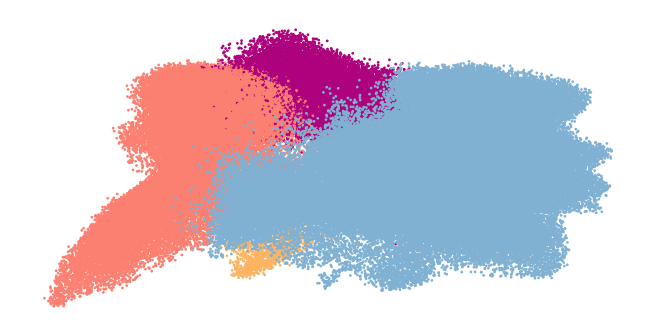

In [18]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=14, figsize=(5,2.5), transparent=True)
subset_order=['Cholangiocyte','Hepatocyte','Mixed','Tumor']

df_subset=adata[adata.obs.Celltype.isin(subset_order)]
sc.pp.pca(df_subset)
sce.pp.harmony_integrate(df_subset, "Sample")
df_subset.obsm['X_pca']=df_subset.obsm['X_pca_harmony']
sc.pp.neighbors(df_subset,n_neighbors=50)
sc.tl.umap(df_subset,spread=1,min_dist=1)

sc.pl.umap(df_subset,color=['Celltype'],s=6,palette=cell_type_colors,
           frameon=False,legend_loc=None,title='')

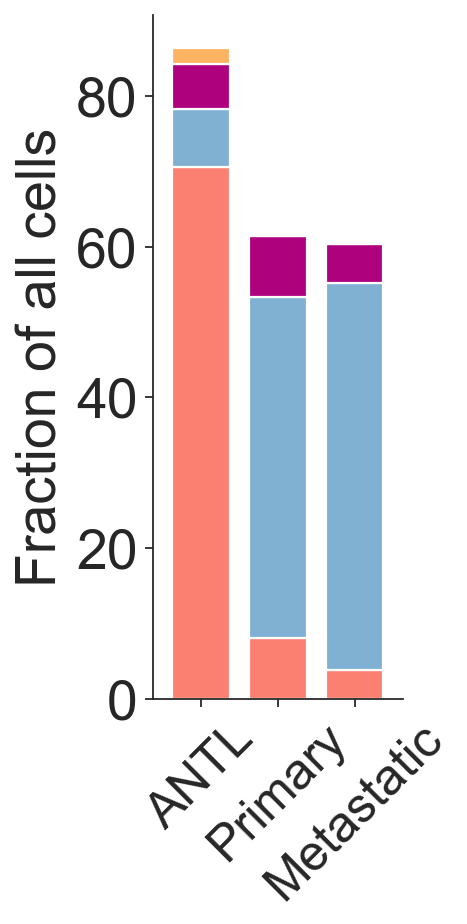

In [19]:
sns.set_style('ticks')
df=df_subset.obs
df_pivot = pd.crosstab(df['Condition'], df['Celltype']).astype(float)
total_count=adata.obs.groupby('Condition',observed=True).Celltype.count()
for x in df_pivot.index:
    df_pivot.loc[x]=df_pivot.loc[x].astype(float)/total_count.loc[x].astype(float)
df_pivot_percentage=df_pivot*100
df_pivot_percentage=df_pivot_percentage[df_pivot_percentage.max().sort_values().index[::-1]].loc[['ANTL','Primary','Metastatic']]
df_pivot_percentage.plot(kind='bar', stacked=True, figsize=(3,6),color=cell_type_colors,width=0.75)
plt.title('')
plt.xlabel('')
plt.ylabel('Fraction of all cells',fontsize=25)
sns.despine()
plt.yticks(fontsize=25)
plt.xticks(np.arange(3),['ANTL','Primary','Metastatic'],fontsize=22.5,rotation=45)
plt.gca().set_axisbelow(True)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show()
plt.close()

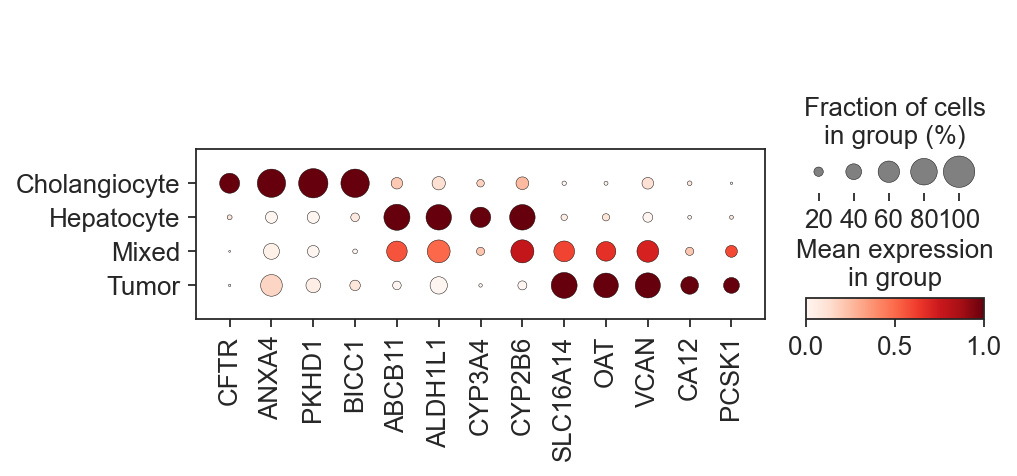

In [20]:
sc.pl.dotplot(df_subset,groupby='Celltype',var_names=['CFTR','ANXA4','PKHD1','BICC1',
                                                'ABCB11','ALDH1L1','CYP3A4','CYP2B6',
                                                'SLC16A14','OAT','VCAN','CA12','PCSK1'],
              standard_scale='var', categories_order=subset_order)

### Figure 1F

/Users/jac/anaconda3/envs/spatialdata/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
2025-08-16 17:12:08,905 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-16 17:12:11,586 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-16 17:12:11,661 - harmonypy - INFO - Iteration 1 of 10
2025-08-16 17:12:15,744 - harmonypy - INFO - Iteration 2 of 10
2025-08-16 17:12:20,101 - harmonypy - INFO - Iteration 3 of 10
2025-08-16 17:12:24,552 - harmonypy - INFO - Iteration 4 of 10
2025-08-16 17:12:28,755 - harmonypy - INFO - Converged after 4 iterations


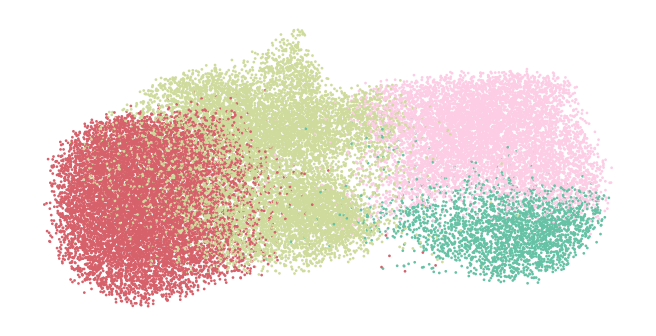

In [21]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=14, figsize=(5,2.5), transparent=True)
subset_order=['HSC','myCAF','vSMC','Pericyte']

df_subset=adata[adata.obs.Celltype.isin(subset_order)]
sc.pp.pca(df_subset)
sce.pp.harmony_integrate(df_subset, "Sample")
df_subset.obsm['X_pca']=df_subset.obsm['X_pca_harmony']
sc.pp.neighbors(df_subset,n_neighbors=50)
sc.tl.umap(df_subset,spread=1,min_dist=1)

sc.pl.umap(df_subset,color=['Celltype'],s=6,palette=cell_type_colors,
           frameon=False,legend_loc=None,title='')

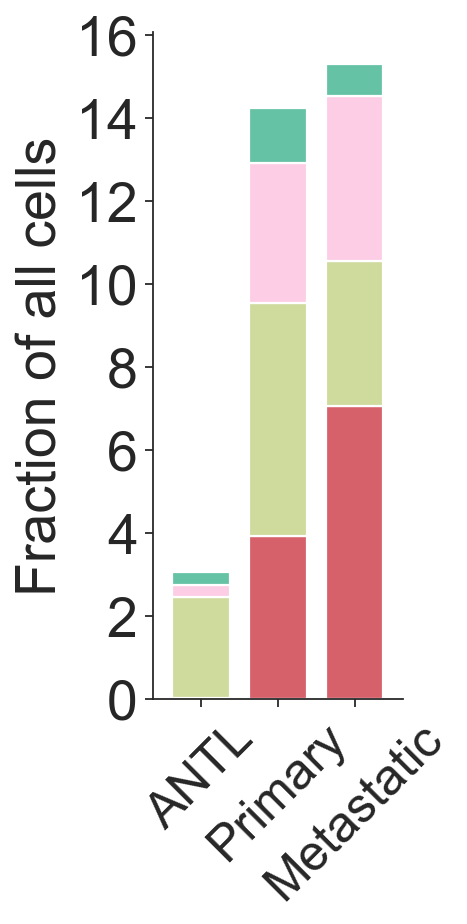

In [22]:
sns.set_style('ticks')
df=df_subset.obs
df_pivot = pd.crosstab(df['Condition'], df['Celltype']).astype(float)
total_count=adata.obs.groupby('Condition',observed=True).Celltype.count()
for x in df_pivot.index:
    df_pivot.loc[x]=df_pivot.loc[x].astype(float)/total_count.loc[x].astype(float)
df_pivot_percentage=df_pivot*100
df_pivot_percentage=df_pivot_percentage[df_pivot_percentage.max().sort_values().index[::-1]].loc[['ANTL','Primary','Metastatic']]
df_pivot_percentage.plot(kind='bar', stacked=True, figsize=(3,6),color=cell_type_colors,width=0.75)
plt.title('')
plt.xlabel('')
plt.ylabel('Fraction of all cells',fontsize=25)
sns.despine()
plt.yticks(fontsize=25)
plt.xticks(np.arange(3),['ANTL','Primary','Metastatic'],fontsize=22.5,rotation=45)
plt.gca().set_axisbelow(True)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show()
plt.close()

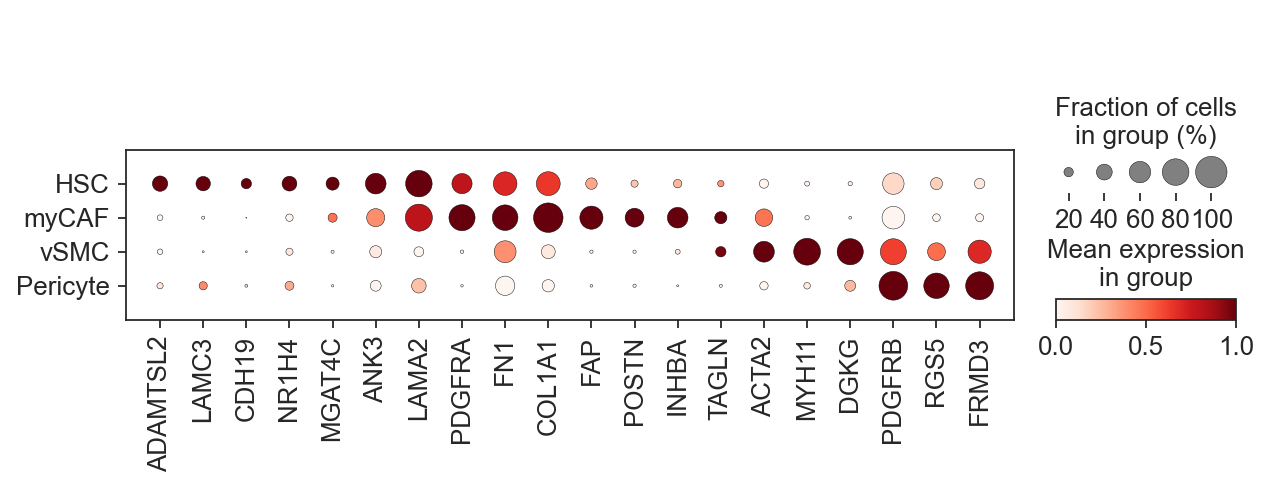

In [23]:
sc.pl.dotplot(df_subset,groupby='Celltype',var_names=['ADAMTSL2','LAMC3','CDH19','NR1H4','MGAT4C','ANK3','LAMA2',
                                                         'PDGFRA','FN1','COL1A1','FAP','POSTN','INHBA','TAGLN','ACTA2',
                                                         'MYH11','DGKG','PDGFRB','RGS5','FRMD3'],
              standard_scale='var', categories_order=subset_order)

### Figure 1G

/Users/jac/anaconda3/envs/spatialdata/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
2025-08-16 17:14:21,141 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-16 17:14:24,466 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-16 17:14:24,583 - harmonypy - INFO - Iteration 1 of 10
2025-08-16 17:14:31,216 - harmonypy - INFO - Iteration 2 of 10
2025-08-16 17:14:37,907 - harmonypy - INFO - Converged after 2 iterations


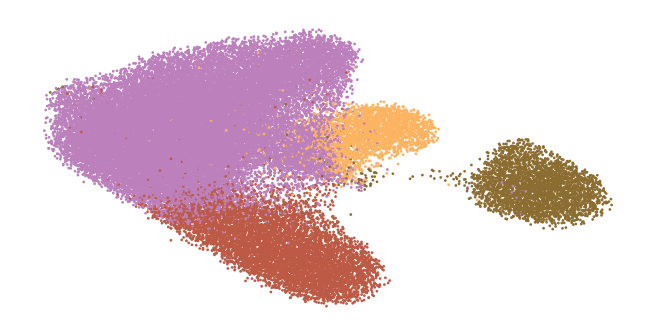

In [24]:
subset_order=['LSEC','Venous','Arterial','LEC']
df_subset=adata[adata.obs.Celltype.isin(subset_order)]
sc.pp.pca(df_subset)
sce.pp.harmony_integrate(df_subset, "Sample")
df_subset.obsm['X_pca']=df_subset.obsm['X_pca_harmony']
sc.pp.neighbors(df_subset,n_neighbors=50)
sc.tl.umap(df_subset,spread=1,min_dist=1)
sc.pl.umap(df_subset,color=['Celltype'],s=6,palette=cell_type_colors,
           frameon=False,legend_loc=None,title='')

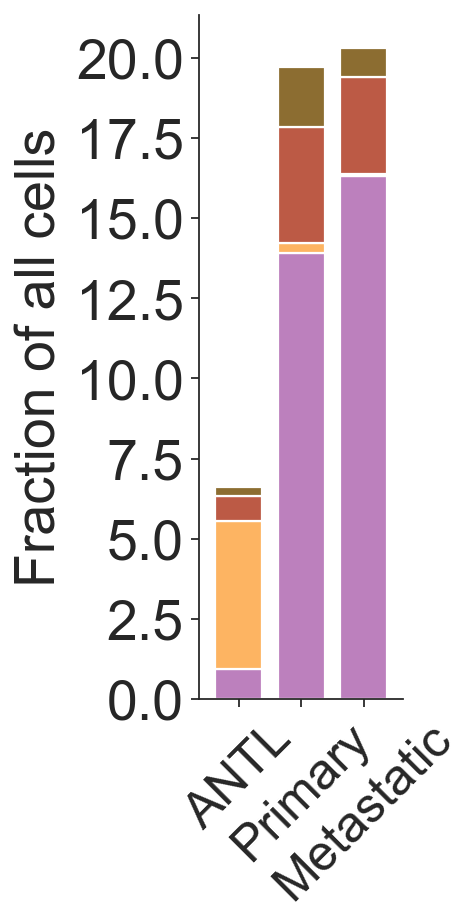

In [25]:
sns.set_style('ticks')
df=df_subset.obs
df_pivot = pd.crosstab(df['Condition'], df['Celltype']).astype(float)
total_count=adata.obs.groupby('Condition',observed=True).Celltype.count()
for x in df_pivot.index:
    df_pivot.loc[x]=df_pivot.loc[x].astype(float)/total_count.loc[x].astype(float)
df_pivot_percentage=df_pivot*100
df_pivot_percentage=df_pivot_percentage[df_pivot_percentage.max().sort_values().index[::-1]].loc[['ANTL','Primary','Metastatic']]
df_pivot_percentage.plot(kind='bar', stacked=True, figsize=(3,6),color=cell_type_colors,width=0.75)
plt.title('')
plt.xlabel('')
plt.ylabel('Fraction of all cells',fontsize=25)
sns.despine()
plt.yticks(fontsize=25)
plt.xticks(np.arange(3),['ANTL','Primary','Metastatic'],fontsize=22.5,rotation=45)
plt.gca().set_axisbelow(True)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show()
plt.close()

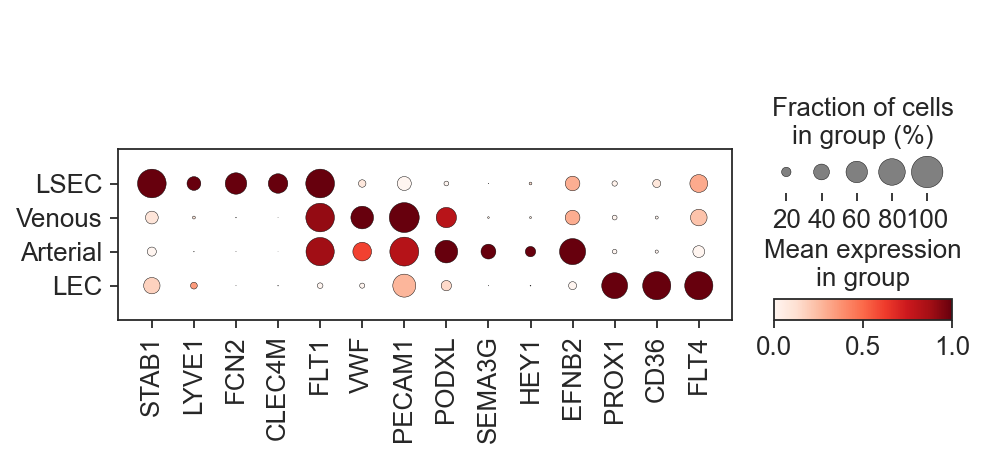

In [26]:
sc.pl.dotplot(df_subset,groupby='Celltype',var_names=['STAB1','LYVE1','FCN2','CLEC4M',
                                                        'FLT1','VWF','PECAM1','PODXL',
                                                        'SEMA3G','HEY1','EFNB2',
                                                        'PROX1','CD36','FLT4'],
              standard_scale='var', categories_order=subset_order)

### Figure 1H

/Users/jac/anaconda3/envs/spatialdata/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
2025-08-16 17:15:35,093 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-16 17:15:36,124 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-16 17:15:36,150 - harmonypy - INFO - Iteration 1 of 10
2025-08-16 17:15:37,164 - harmonypy - INFO - Iteration 2 of 10
2025-08-16 17:15:38,102 - harmonypy - INFO - Converged after 2 iterations


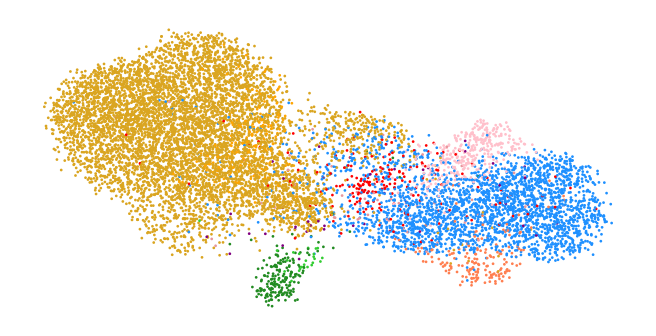

In [27]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=14, figsize=(5,2.5), transparent=True)
subset_order=['Macrophage','Kupffer cell',
                'cDC','mregDC','pDC','T cell','Treg',
                'NK cell','B cell','Mast cell']

df_subset=adata[adata.obs.Celltype.isin(subset_order)]
sc.pp.pca(df_subset)
sce.pp.harmony_integrate(df_subset, "Sample")
df_subset.obsm['X_pca']=df_subset.obsm['X_pca_harmony']
sc.pp.neighbors(df_subset,n_neighbors=50)
sc.tl.umap(df_subset,spread=1,min_dist=1)

sc.pl.umap(df_subset,color=['Celltype'],s=6,palette=cell_type_colors,
           frameon=False,legend_loc=None,title='')

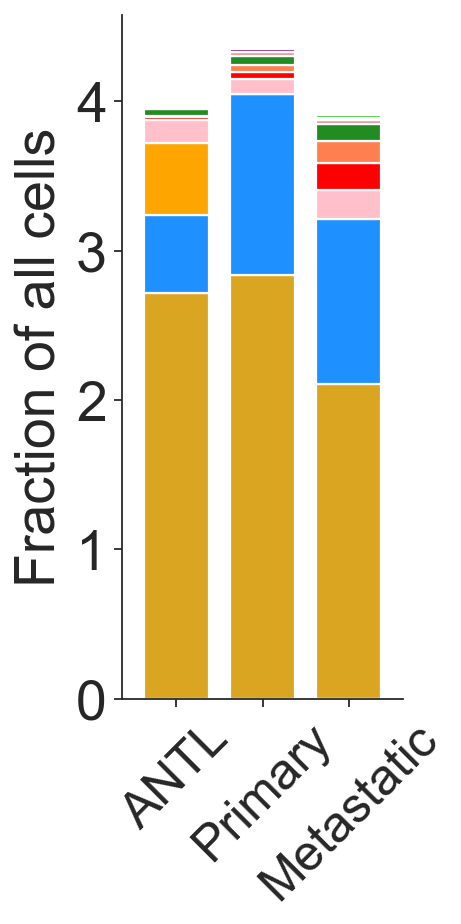

In [28]:
sns.set_style('ticks')
df=df_subset.obs
df_pivot = pd.crosstab(df['Condition'], df['Celltype']).astype(float)
total_count=adata.obs.groupby('Condition',observed=True).Celltype.count()
for x in df_pivot.index:
    df_pivot.loc[x]=df_pivot.loc[x].astype(float)/total_count.loc[x].astype(float)
df_pivot_percentage=df_pivot*100
df_pivot_percentage=df_pivot_percentage[df_pivot_percentage.max().sort_values().index[::-1]].loc[['ANTL','Primary','Metastatic']]
df_pivot_percentage.plot(kind='bar', stacked=True, figsize=(3,6),color=cell_type_colors,width=0.75)
plt.title('')
plt.xlabel('')
plt.ylabel('Fraction of all cells',fontsize=25)
sns.despine()
plt.yticks(fontsize=25)
plt.xticks(np.arange(3),['ANTL','Primary','Metastatic'],fontsize=22.5,rotation=45)
plt.gca().set_axisbelow(True)
plt.legend('',frameon=False)
plt.tight_layout()
plt.show()
plt.close()

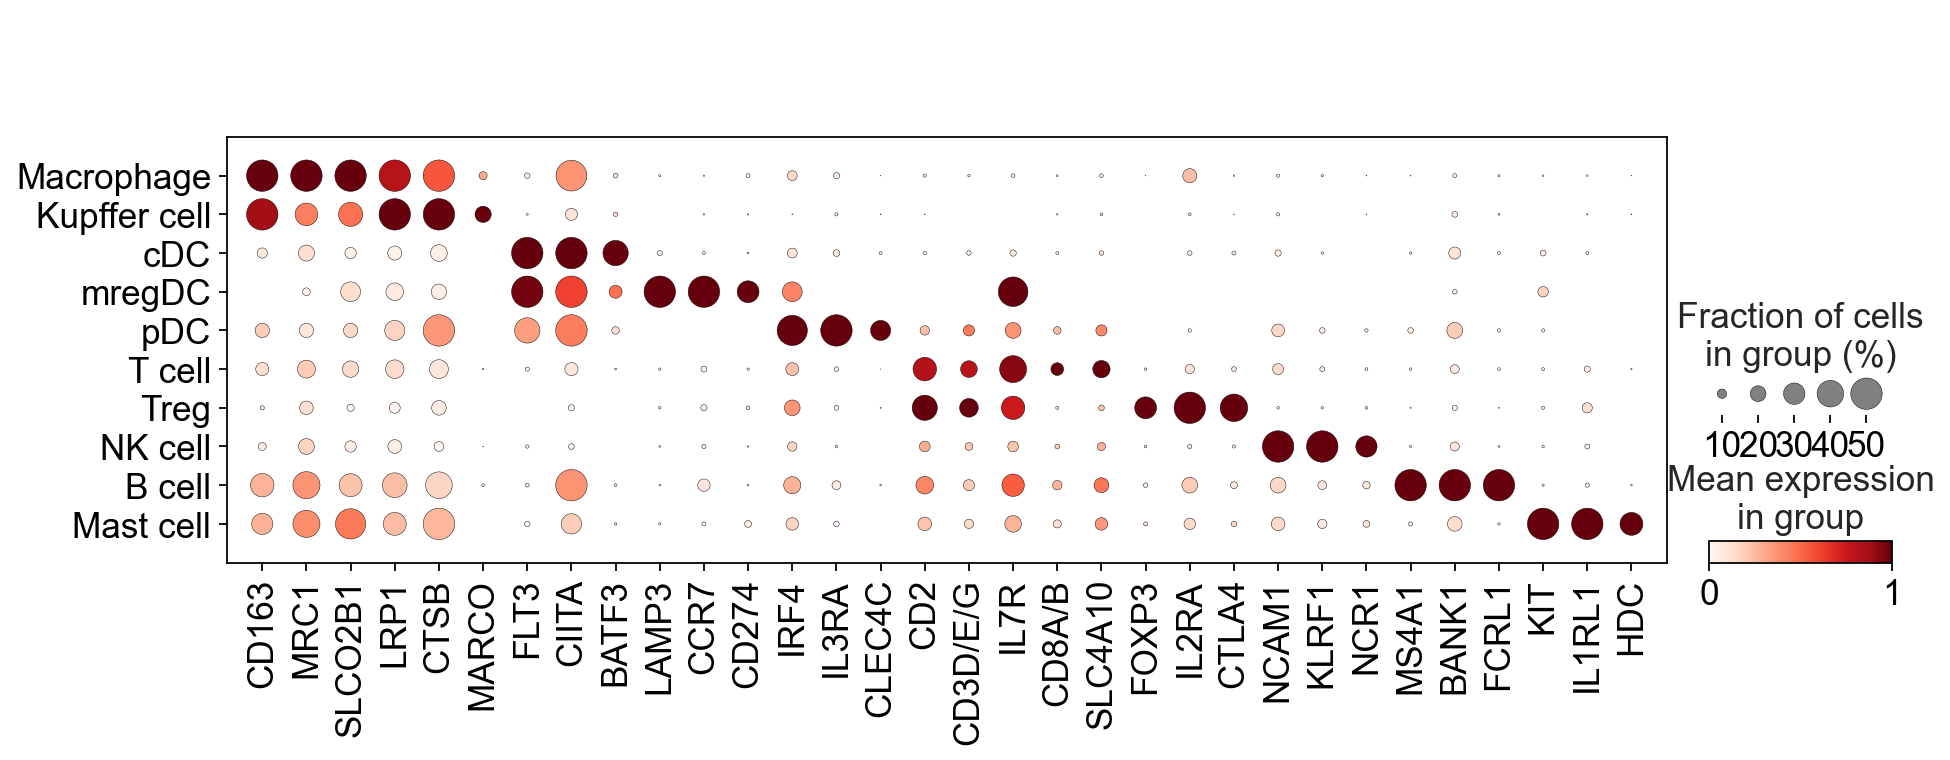

In [29]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=19, figsize=(5,2.5), transparent=True)
sc.tl.score_genes(df_subset, ['CD3D','CD3E','CD3G'], score_name='CD3D/E/G')
sc.tl.score_genes(df_subset, ['CD8A','CD8B'], score_name='CD8A/B')
sc.pl.dotplot(df_subset,groupby='Celltype',var_names=['CD163','MRC1','SLCO2B1',
                                                   'LRP1','CTSB','MARCO',
                                                   'FLT3','CIITA','BATF3',
                                                   'LAMP3','CCR7','CD274',
                                                   'IRF4','IL3RA','CLEC4C',
                                                   'CD2','CD3D/E/G','IL7R','CD8A/B','SLC4A10',
                                                   'FOXP3','IL2RA','CTLA4',
                                                   'NCAM1','KLRF1','NCR1',
                                                   'MS4A1','BANK1','FCRL1',
                                                  'KIT','IL1RL1','HDC'],
              dot_max=0.5,standard_scale='var',categories_order=subset_order)

### Figure 3F

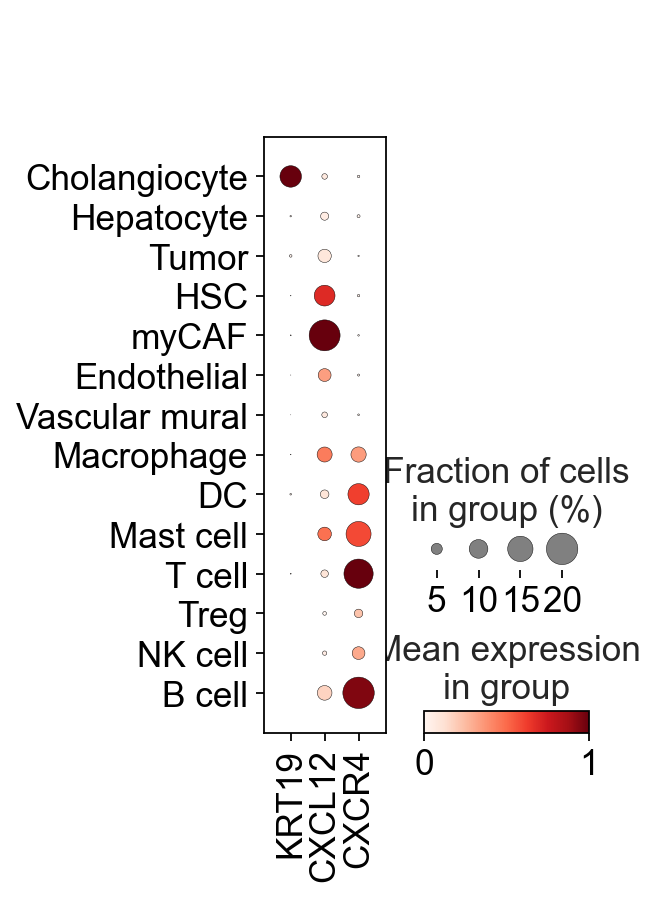

In [30]:
sc.pl.dotplot(adata,groupby='Celltype_forCellchat',var_names=['KRT19','CXCL12','CXCR4'],standard_scale='var',dot_max=.20,
             categories_order=['Cholangiocyte','Hepatocyte','Tumor','HSC','myCAF','Endothelial','Vascular mural',
                              'Macrophage','DC','Mast cell','T cell','Treg','NK cell','B cell'])